In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from scipy.stats import cauchy
import random
import sympy as sp
from scipy.optimize import fsolve
import matplotlib.patches as mpatches

In [2]:
# Define parameters
N = 5000
T = 300
M = 50000
dt = 0.01
t0 = 0

pi = np.pi

k = 1
a = 0.1
b = 0.26
c = -65
d = 0 #-1

A = 0.04
B = 5
C = 140

# v_reset = -10/A - B/(2*A)
# v_thresh = 10/A - B/(2*A) 

v_reset = -1000
v_thresh = 1000

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

p_jump = 2.7185823035951033

# Heterogeneity parameters for the intrinsic current eta
Delta = 0.02     # half-width of Lorentzian for eta
etaBar = 0.5     # mean intrinsic current

J = stats.cauchy.rvs(loc=etaBar, scale=Delta, size=N)
I = 0

# All-to-all connected, can use single s and p as all neuron receive same input
g = 0.4

In [3]:
# Network simulation functions
def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N]
    p = x[-1]
    
    dvdt = k * (A*v**2 + B*v + C - u + I) + J - (v - Esyn)*g*s
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, [dsdt], [dpdt]])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

In [4]:
# Define the mean-field ODE system
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g*s)*r + 2.0*A*r*v +  Delta*A/pi
    dvdt = - (pi**2 / A)*(r**2) + A*(v**2) + B*v + C - u + I + etaBar + g*s*(Esyn - v)
    dudt = a*(b*v - u) + d*r
    dsdt = - s / tauS + p / tauS
    dpdt = -(p/tauS) + p_jump*r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Fixed Point, Bifurcation Analysis  and Trajectory Plot for $\bar{\eta}$ 

In [5]:
# Physical FP r>0
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [0.12 , -62]  # initial guesses for r, v
etaBar_values = np.linspace(-0.35, 1.0, 28)

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar, Delta))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar, Delta))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

etaBar = -0.35, Fixed point (r, v, u, s, p): 0.002311424666332575, -63.78150621294265, -16.58319161536509, 0.019121868378092353, 0.019121868378092353
Residuals (should be close to zero):
dr/dt, dv/dt: [5.101171221544298e-16, -1.7111312367035225e-14]
du/dt, ds/dt, dp/dt: [0.0, 8.673617379884035e-19, 8.673617379884035e-19]
etaBar = -0.30, Fixed point (r, v, u, s, p): 0.002522708112126525, -63.65742967044513, -16.550931714315734, 0.020869766243763226, 0.020869766243763226
Residuals (should be close to zero):
dr/dt, dv/dt: [-1.3269550389050089e-15, 1.508099201075197e-13]
du/dt, ds/dt, dp/dt: [0.0, 8.673617379884035e-19, 8.673617379884035e-19]
etaBar = -0.25, Fixed point (r, v, u, s, p): 0.0027734934599493583, -63.53296345852653, -16.5185704992169, 0.022944453981621062, 0.022944453981621062
Residuals (should be close to zero):
dr/dt, dv/dt: [-4.2222085203103e-15, 1.2194828480360798e-12]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
etaBar = -0.20, Fixed point (r, v, u, s, p): 0.003072614637344389, -

In [6]:
# Physical FP r>0
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [0.12 , -62]  # initial guesses for r, v
etaBar_values = [0.5]

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar, Delta))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar, Delta))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

etaBar = 0.50, Fixed point (r, v, u, s, p): 0.014028357473789953, -62.146638220985416, -16.15812593745621, 0.11605327618150599, 0.11605327618150599
Residuals (should be close to zero):
dr/dt, dv/dt: [-4.771529308819633e-13, 1.9482082613819784e-11]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


In [7]:
# Unphysical FP r<0
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [-0.12 , -62]  # initial guesses for r, v
etaBar_values = np.linspace(-0.35, 1.0, 28)

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar,Delta))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

etaBar = -0.35, Fixed point (r, v, u, s, p): -0.1016931339598754, -66.67511494240439, -17.335529885025142, -0.8412831925090573, -0.8412831925090573
Residuals (should be close to zero):
dr/dt, dv/dt: [2.205576108034457e-12, 9.664047340152138e-12]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
etaBar = -0.30, Fixed point (r, v, u, s, p): -0.10341752800007126, -66.74696437415723, -17.35421073728088, -0.8555486956633996, -0.8555486956633996
Residuals (should be close to zero):
dr/dt, dv/dt: [-3.537100083314537e-13, -4.839462164341057e-12]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
etaBar = -0.25, Fixed point (r, v, u, s, p): -0.10508054525719189, -66.81624022582656, -17.372222458714905, -0.8693064432397514, -0.8693064432397514
Residuals (should be close to zero):
dr/dt, dv/dt: [-2.718865714165797e-13, -3.495204126124918e-12]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
etaBar = -0.20, Fixed point (r, v, u, s, p): -0.10668831309205624, -66.88320013002804, -17.389632033807292, -0.8826071254417744, -0.88260712544177

In [8]:
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar,Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [-0.12 , -62]  # initial guesses for r, v
etaBar_values = [0.5]

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar,Delta))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

etaBar = 0.50, Fixed point (r, v, u, s, p): -0.12535460538005738, -67.6597519293294, -17.591535501625646, -1.0370289369925219, -1.0370289369925219
Residuals (should be close to zero):
dr/dt, dv/dt: [-5.9881570188546895e-15, -2.6233459848867824e-12]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


In [9]:
r_fp, v_fp, u_fp, s_fp, p_fp =0.01402835747175809, -62.14663822067612, -16.15812593737579, 0.11605327616469685, 0.11605327616469685
etaBar = 0.5
# Jacobian matrix at the fixed point
J = np.zeros((5, 5))

# Evaluate explicitly at fixed points
J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
J[0, 1] = 2.0 * A * r_fp
J[0, 2] = 0
J[0, 3] = -g * r_fp
J[0, 4] = 0

J[1, 0] = -(2 * pi**2 / A) * r_fp
J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
J[1, 2] = -1
J[1, 3] = g * (Esyn - v_fp)
J[1, 4] = 0

J[2, 0] = d
J[2, 1] = a * b
J[2, 2] = -a
J[2, 3] = 0
J[2, 4] = 0

J[3, 0] = 0
J[3, 1] = 0
J[3, 2] = 0
J[3, 3] = -1 / tauS
J[3, 4] = 1 / tauS

J[4, 0] = p_jump
J[4, 1] = 0
J[4, 2] = 0
J[4, 3] = 0
J[4, 4] = -1 / tauS

# Print Jacobian matrix
print("Jacobian matrix evaluated at the fixed point:")
print(J)
eigvals, eigvecs = np.linalg.eig(J)

# Print eigenvalues and eigenvectors explicitly
for idx, eigval in enumerate(eigvals):
    eigvec = eigvecs[:, idx]
    print(f"Eigenvalue {idx+1}: {eigval}")
    print(f"Corresponding eigenvector:\n{eigvec}\n")
max_real_eigenvalue = np.max(np.real(eigvals))
print(f"Maximum real eigenvalue: {max_real_eigenvalue}")

Jacobian matrix evaluated at the fixed point:
[[-1.81523681e-02  1.12226860e-03  0.00000000e+00 -5.61134299e-03
   0.00000000e+00]
 [-6.92271693e+00 -1.81523681e-02 -1.00000000e+00 -3.14134471e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.60000000e-02 -1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.28618421e-01
   3.28618421e-01]
 [ 2.71858230e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.28618421e-01]]
Eigenvalue 1: (-0.3515694359975669+0.0785202510253479j)
Corresponding eigenvector:
[ 9.17271800e-04+0.00045832j -9.85216858e-01+0.j
  9.27842970e-02+0.02895998j -1.36127189e-01+0.01439723j
  6.06716754e-03-0.03353182j]

Eigenvalue 2: (-0.3515694359975669-0.0785202510253479j)
Corresponding eigenvector:
[ 9.17271800e-04-0.00045832j -9.85216858e-01-0.j
  9.27842970e-02-0.02895998j -1.36127189e-01-0.01439723j
  6.06716754e-03+0.03353182j]

Eigenvalue 3: (0.007302142207063752+0.208450873211366j)
Corresponding eigenvector:
[ 0.0

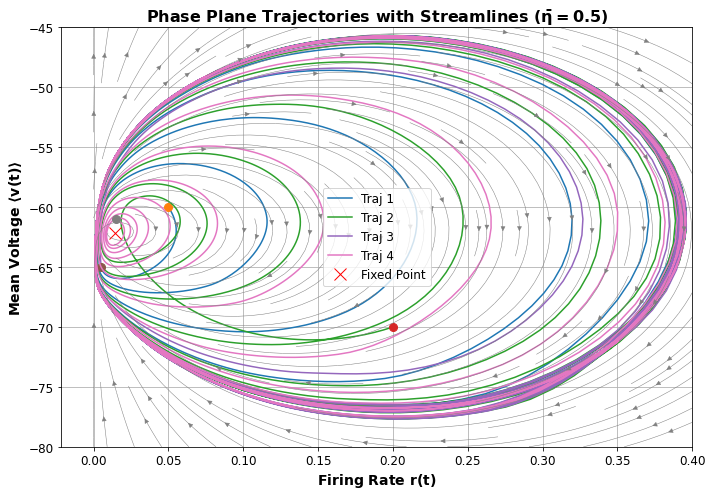

In [10]:
r_fp, v_fp, u_fp, s_fp, p_fp = 0.01402835747175809, -62.14663822067612, -16.15812593737579, 0.11605327616469685, 0.11605327616469685
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.4, 25)
v = np.linspace(-80, -45, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines
plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.grid(True)
plt.title(r"Phase Plane Trajectories with Streamlines $\mathbf{(\bar{\eta} = 0.5)}$", fontsize=16, fontweight='bold')
plt.ylabel(r"Mean Voltage $\mathbf{\langle v(t) \rangle }$", fontsize=14, fontweight='bold')
plt.xlabel(r"Firing Rate $\mathbf{r(t)}$", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('TrajectoryPlot_EtaBar_0.5.png')
plt.show()

In [11]:
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [0.12 , -62]  # initial guesses for r, v
etaBar_values = [0.1]

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar,Delta))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

etaBar = 0.10, Fixed point (r, v, u, s, p): 0.006378277703089818, -62.73522313967334, -16.31115801631507, 0.05276597956831532, 0.05276597956831532
Residuals (should be close to zero):
dr/dt, dv/dt: [-2.1499729080387553e-16, 7.954747971439247e-14]
du/dt, ds/dt, dp/dt: [0.0, 3.469446951953614e-18, 3.469446951953614e-18]


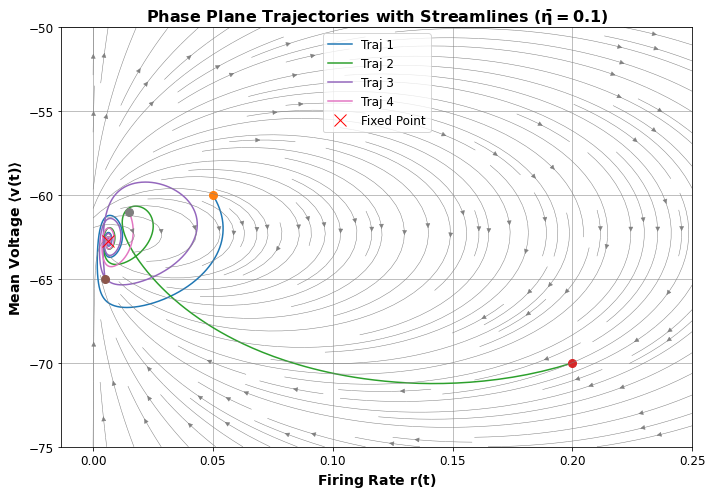

In [12]:
r_fp = 0.006378277703089818
v_fp = -62.73522313967334 
u_fp = -16.31115801631507
s_fp = 0.05276597956831532
p_fp = 0.05276597956831532
etaBar = 0.1
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.25, 25)
v = np.linspace(-75, -50, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines

plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.grid(True)
plt.title(r"Phase Plane Trajectories with Streamlines $\mathbf{(\bar{\eta} = 0.1)}$", fontsize=16, fontweight='bold')
plt.ylabel(r"Mean Voltage $\mathbf{\langle v(t) \rangle }$", fontsize=14, fontweight='bold')
plt.xlabel(r"Firing Rate $\mathbf{r(t)}$", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('TrajectoryPlot_EtaBar_0.1.png')
plt.show()

etaBar = 0.0, Max real eigenvalue: -0.046013, Stability: Stable, Fixed Point: 0.0049490549791282
etaBar = 0.010101010101010102, Max real eigenvalue: -0.044629, Stability: Stable, Fixed Point: 0.005078396574368269
etaBar = 0.020202020202020204, Max real eigenvalue: -0.043247, Stability: Stable, Fixed Point: 0.005211230750663535
etaBar = 0.030303030303030304, Max real eigenvalue: -0.041870, Stability: Stable, Fixed Point: 0.005347529373195363
etaBar = 0.04040404040404041, Max real eigenvalue: -0.040498, Stability: Stable, Fixed Point: 0.005487254532570519
etaBar = 0.05050505050505051, Max real eigenvalue: -0.039132, Stability: Stable, Fixed Point: 0.005630358859510237
etaBar = 0.06060606060606061, Max real eigenvalue: -0.037773, Stability: Stable, Fixed Point: 0.005776785955047865
etaBar = 0.07070707070707072, Max real eigenvalue: -0.036421, Stability: Stable, Fixed Point: 0.005926470925464443
etaBar = 0.08080808080808081, Max real eigenvalue: -0.035079, Stability: Stable, Fixed Point: 0

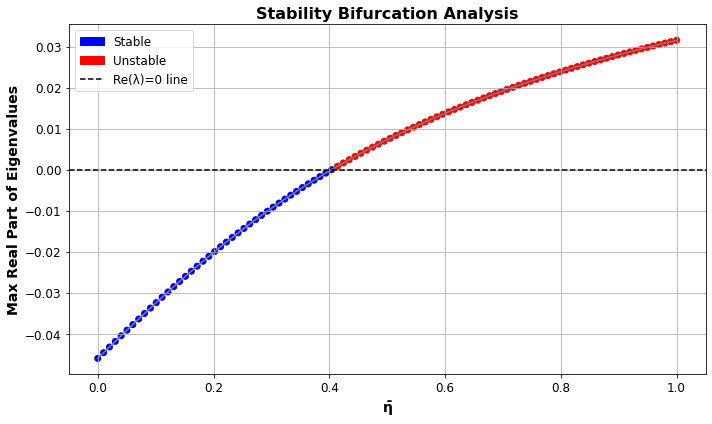

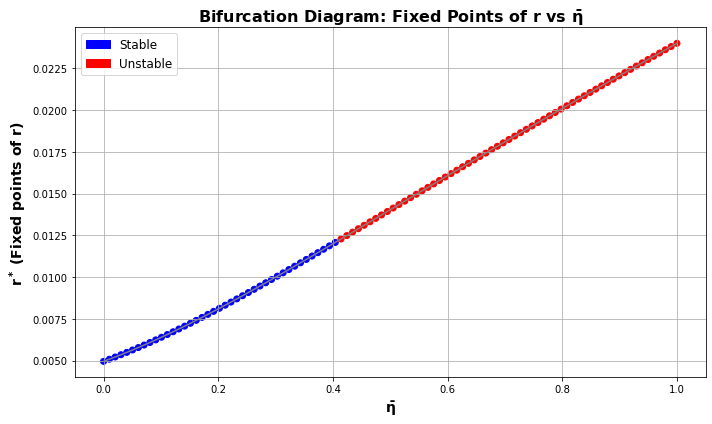

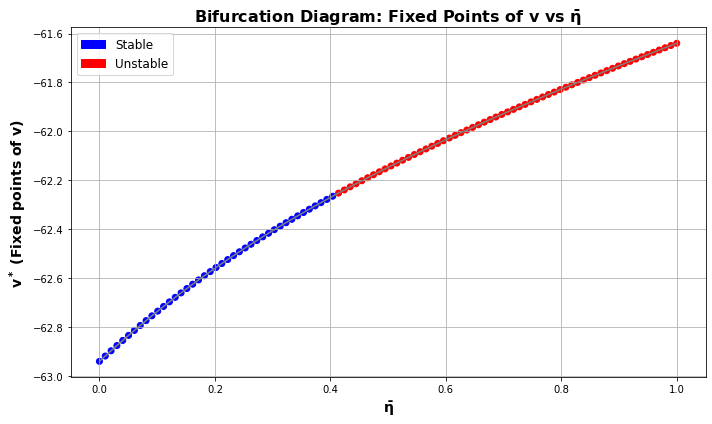

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.optimize import fsolve

# Storage arrays
etaBar_values = np.linspace(0, 1, 100)
max_real_eigvals = []
r_fixed = []
v_fixed = []
stabilities = []
Delta = 0.02
# Initial guess
initial_guess = [0.0120 , -62.2695]

for etaBar in etaBar_values:
    fixed_point, _, ier, _ = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta,), full_output=True)
    if ier == 1:
        r_fp, v_fp = fixed_point
        u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)
        
        # Jacobian at the fixed point
        J = np.zeros((5, 5))
        J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
        J[0, 1] = 2.0 * A * r_fp
        J[0, 3] = -g * r_fp

        J[1, 0] = -(2 * np.pi**2 / A) * r_fp
        J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
        J[1, 2] = -1
        J[1, 3] = g * (Esyn - v_fp)

        J[2, 0] = d
        J[2, 1] = a * b
        J[2, 2] = -a

        J[3, 3] = -1 / tauS
        J[3, 4] = 1 / tauS

        J[4, 0] = p_jump
        J[4, 4] = -1 / tauS

        eigvals = np.linalg.eigvals(J)
        max_real_part = np.max(eigvals.real)

        max_real_eigvals.append(max_real_part)
        r_fixed.append(r_fp)
        v_fixed.append(v_fp)
        stabilities.append('Stable' if max_real_part < 0 else 'Unstable')

        print(f"etaBar = {etaBar:}, Max real eigenvalue: {max_real_part:.6f}, Stability: {stabilities[-1]}, Fixed Point: {r_fp}")

        # Update initial guess for next iteration
        initial_guess = [r_fp, v_fp]

# Convert to arrays
max_real_eigvals = np.array(max_real_eigvals)
r_fixed = np.array(r_fixed)
v_fixed = np.array(v_fixed)
etaBar_values = np.array(etaBar_values)
stabilities = np.array(stabilities)

# Define colors based on stability
colors = ['blue' if s == 'Stable' else 'red' for s in stabilities]

# Custom legend handles
stable_patch = mpatches.Patch(color='blue', label='Stable')
unstable_patch = mpatches.Patch(color='red', label='Unstable')

# Plot max eigenvalue vs etaBar with color change
plt.figure(figsize=(10,6))
plt.plot(etaBar_values, max_real_eigvals, color='gray')
plt.scatter(etaBar_values, max_real_eigvals, c=colors)
plt.axhline(0, color='black', linestyle='--', label='Re(λ)=0 line')
plt.xlabel(r'$\mathbf{\bar{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel('Max Real Part of Eigenvalues', fontsize=14, fontweight='bold')
plt.title('Stability Bifurcation Analysis', fontsize = 16, fontweight = 'bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch, 
                     plt.Line2D([0], [0], color='black', linestyle='--', label="Re(λ)=0 line")], fontsize = 12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram.png')
plt.show()



# New plot: r* (Fixed points of r) vs etaBar
plt.figure(figsize=(10,6))
plt.scatter(etaBar_values, r_fixed, c=colors)
plt.plot(etaBar_values, r_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{\bar{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{r^*}$ (Fixed points of $\mathbf{r}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: Fixed Points of $\mathbf{r}$ vs $\mathbf{\bar{\eta}}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram_fp_r.png')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(etaBar_values, v_fixed, c=colors)
plt.plot(etaBar_values, v_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{\bar{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{v^*}$ (Fixed points of $\mathbf{v}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: Fixed Points of $\mathbf{v}$ vs $\mathbf{\bar{\eta}}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram_fp_v.png')
plt.show()

In [16]:
tol = 1e-12  # precision tolerance

eta_stable = 0.40404609375
eta_unstable = 0.40404612500

initial_guess = [0.01, -65]

while abs(eta_unstable - eta_stable) > tol:
    eta_mid = (eta_stable + eta_unstable) / 2
    
    # Solve fixed points at midpoint explicitly
    fixed_point, _, ier, _ = fsolve(fixed_point_equations, initial_guess, args=(eta_mid,Delta), full_output=True)
    
    if ier == 1:
        r_fp, v_fp = fixed_point
        u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

        # Jacobian at midpoint explicitly
        J = np.zeros((5, 5))
        J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
        J[0, 1] = 2.0 * A * r_fp
        J[0, 3] = -g * r_fp

        J[1, 0] = -(2 * np.pi**2 / A) * r_fp
        J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
        J[1, 2] = -1
        J[1, 3] = g * (Esyn - v_fp)

        J[2, 0] = d
        J[2, 1] = a * b
        J[2, 2] = -a

        J[3, 3] = -1 / tauS
        J[3, 4] = 1 / tauS

        J[4, 0] = p_jump
        J[4, 4] = -1 / tauS

        eigvals = np.linalg.eigvals(J)
        max_real_part = np.max(eigvals.real)

        if max_real_part < 0:
            eta_stable = eta_mid
        else:
            eta_unstable = eta_mid

        # Update initial guess explicitly
        initial_guess = [r_fp, v_fp]

# Final bifurcation point
eta_bifurcation = (eta_stable + eta_unstable) / 2
print(f"Precise Bifurcation point at etaBar = {eta_bifurcation:}")


Precise Bifurcation point at etaBar = 0.4040461000933647


In [18]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar,Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [0.01, -65]  # initial guesses for r, v
etaBar_values = [0.4040461000933647]

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar,Delta))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]


etaBar = 0.4040461000933647, Fixed point (r, v, u, s, p): 0.012072306109482353, -62.2643128610609, -16.188721343875834, 0.09987132689547366, 0.09987132689547366
Residuals (should be close to zero):
dr/dt, dv/dt: [-2.629732369363591e-15, 1.9328982858723975e-13]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


In [19]:
r_fp = 0.012072306077469041
v_fp = -62.26431285864538
u_fp = -16.1887213432478
s_fp = 0.09987132663063512
p_fp = 0.09987132663063512
etaBar = 0.4040461000933647
# Jacobian matrix at the fixed point
J = np.zeros((5, 5))

# Evaluate explicitly at fixed points
J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
J[0, 1] = 2.0 * A * r_fp
J[0, 2] = 0
J[0, 3] = -g * r_fp
J[0, 4] = 0

J[1, 0] = -(2 * pi**2 / A) * r_fp
J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
J[1, 2] = -1
J[1, 3] = g * (Esyn - v_fp)
J[1, 4] = 0

J[2, 0] = d
J[2, 1] = a * b
J[2, 2] = -a
J[2, 3] = 0
J[2, 4] = 0

J[3, 0] = 0
J[3, 1] = 0
J[3, 2] = 0
J[3, 3] = -1 / tauS
J[3, 4] = 1 / tauS

J[4, 0] = p_jump
J[4, 1] = 0
J[4, 2] = 0
J[4, 3] = 0
J[4, 4] = -1 / tauS

# Print Jacobian matrix
print("Jacobian matrix evaluated at the fixed point:")
print(J)
eigvals, eigvecs = np.linalg.eig(J)

# Print eigenvalues and eigenvectors explicitly
for idx, eigval in enumerate(eigvals):
    eigvec = eigvecs[:, idx]
    print(f"Eigenvalue {idx+1}: {eigval}")
    print(f"Corresponding eigenvector:\n{eigvec}\n")
max_real_eigenvalue = np.max(np.real(eigvals))
print(f"Maximum real eigenvalue: {max_real_eigenvalue}")

Jacobian matrix evaluated at the fixed point:
[[-2.10935593e-02  9.65784486e-04  0.00000000e+00 -4.82892243e-03
   0.00000000e+00]
 [-5.95744426e+00 -2.10935593e-02 -1.00000000e+00 -3.09427486e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.60000000e-02 -1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.28618421e-01
   3.28618421e-01]
 [ 2.71858230e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.28618421e-01]]
Eigenvalue 1: (-0.34897721888642025+0.07340618258246716j)
Corresponding eigenvector:
[ 8.05678331e-04+0.00038094j -9.85102595e-01+0.j
  9.46445287e-02+0.02790413j -1.36524186e-01+0.0136184j
  5.41598932e-03-0.03134022j]

Eigenvalue 2: (-0.34897721888642025-0.07340618258246716j)
Corresponding eigenvector:
[ 8.05678331e-04-0.00038094j -9.85102595e-01-0.j
  9.46445287e-02-0.02790413j -1.36524186e-01-0.0136184j
  5.41598932e-03+0.03134022j]

Eigenvalue 3: (1.1037006074324404e-10+0.19965787256254647j)
Corresponding eigenvector:

# Fixed Point, Bifurcation Analysis  and Trajectory Plot for $\Delta_{\eta}$ 

Δη = 0.000000, Max Re(λ): 0.016206, Stability: Unstable
Δη = 0.001000, Max Re(λ): 0.015719, Stability: Unstable
Δη = 0.002000, Max Re(λ): 0.015237, Stability: Unstable
Δη = 0.003000, Max Re(λ): 0.014761, Stability: Unstable
Δη = 0.004000, Max Re(λ): 0.014289, Stability: Unstable
Δη = 0.005000, Max Re(λ): 0.013822, Stability: Unstable
Δη = 0.006000, Max Re(λ): 0.013359, Stability: Unstable
Δη = 0.007000, Max Re(λ): 0.012901, Stability: Unstable
Δη = 0.008000, Max Re(λ): 0.012447, Stability: Unstable
Δη = 0.009000, Max Re(λ): 0.011998, Stability: Unstable
Δη = 0.010000, Max Re(λ): 0.011552, Stability: Unstable
Δη = 0.011000, Max Re(λ): 0.011111, Stability: Unstable
Δη = 0.012000, Max Re(λ): 0.010673, Stability: Unstable
Δη = 0.013000, Max Re(λ): 0.010240, Stability: Unstable
Δη = 0.014000, Max Re(λ): 0.009810, Stability: Unstable
Δη = 0.015000, Max Re(λ): 0.009383, Stability: Unstable
Δη = 0.016000, Max Re(λ): 0.008960, Stability: Unstable
Δη = 0.017000, Max Re(λ): 0.008541, Stability: U

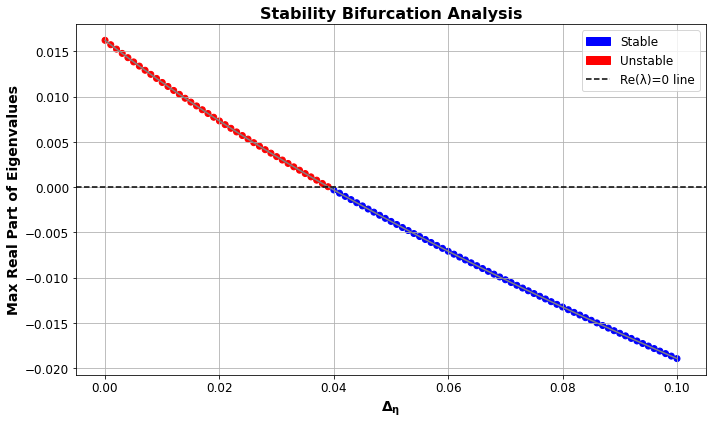

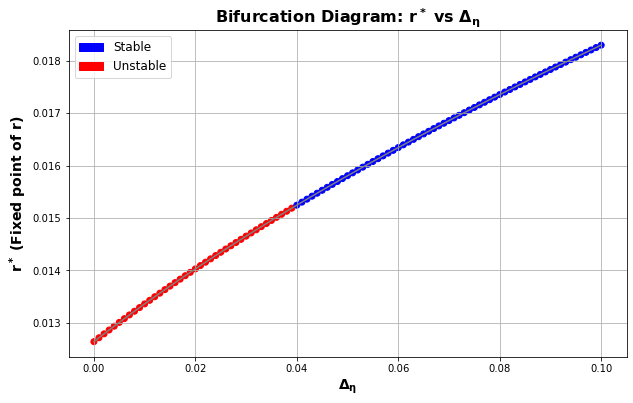

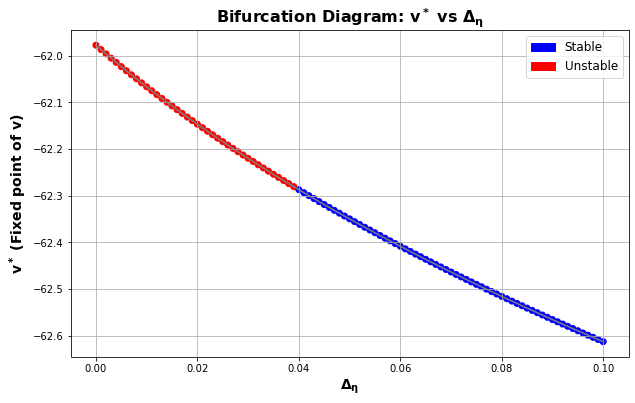

In [36]:
Delta_values = np.linspace(0,0.1,101)
etaBar = 0.5  # Held constant for this sweep

# Storage
delta_success = []
max_real_eigvals = []
r_fixed = []
v_fixed = []
stabilities = []
eigenvalue_records = []

initial_guess = [0.12, -62]

# --- Loop over Delta_eta values ---
for Delta_eta in Delta_values:
    fixed_point, _, ier, _ = fsolve(fixed_point_equations, initial_guess, args=(etaBar, Delta_eta,), full_output=True)

    if ier == 1:
        r_fp, v_fp = fixed_point
        u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

        # Construct Jacobian
        J = np.zeros((5, 5))
        J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
        J[0, 1] = 2.0 * A * r_fp
        J[0, 3] = -g * r_fp

        J[1, 0] = -(2 * np.pi**2 / A) * r_fp
        J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
        J[1, 2] = -1
        J[1, 3] = g * (Esyn - v_fp)

        J[2, 0] = d
        J[2, 1] = a * b
        J[2, 2] = -a

        J[3, 3] = -1 / tauS
        J[3, 4] = 1 / tauS

        J[4, 0] = p_jump
        J[4, 4] = -1 / tauS

        # Calculate eigenvalues
        eigvals = np.linalg.eigvals(J)
        eigenvalue_records.append((Delta_eta, eigvals.copy()))  # Save for inspection

        # Track stability and fixed points
        max_real_part = np.max(eigvals.real)
        max_real_eigvals.append(max_real_part)
        r_fixed.append(r_fp)
        v_fixed.append(v_fp)
        stabilities.append('Stable' if max_real_part < 0 else 'Unstable')
        delta_success.append(Delta_eta)

        print(f"Δη = {Delta_eta:.6f}, Max Re(λ): {max_real_part:.6f}, Stability: {stabilities[-1]}")
        initial_guess = [r_fp, v_fp]

# Convert to arrays
delta_success = np.array(delta_success)
max_real_eigvals = np.array(max_real_eigvals)
r_fixed = np.array(r_fixed)
v_fixed = np.array(v_fixed)
stabilities = np.array(stabilities)

# --- Print eigenvalues near bifurcation point ---
print("\n--- Eigenvalues near bifurcation (Δη ≈  0.039117) ---")
for Delta_eta, eigs in eigenvalue_records:
    if  0.0390 <= Delta_eta <=  0.0392:
        print(f"\nΔη = {Delta_eta:.6f}")
        for idx, eig in enumerate(eigs):
            re = eig.real
            im = eig.imag
            sign = '+' if im >= 0 else '-'
            print(f"  λ_{idx+1} = {re:.4f} {sign} {abs(im):.4f}i")

# --- Plotting ---
colors = ['blue' if s == 'Stable' else 'red' for s in stabilities]
stable_patch = mpatches.Patch(color='blue', label='Stable')
unstable_patch = mpatches.Patch(color='red', label='Unstable')

# Plot: Max real eigenvalue vs Delta_eta
plt.figure(figsize=(10, 6))
plt.plot(delta_success, max_real_eigvals, color='gray')
plt.scatter(delta_success, max_real_eigvals, c=colors)
plt.axhline(0, color='black', linestyle='--', label='Re(λ)=0 line')
plt.xlabel(r'$\mathbf{\Delta_{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel('Max Real Part of Eigenvalues', fontsize=14, fontweight='bold')
plt.title('Stability Bifurcation Analysis', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[
    stable_patch,
    unstable_patch,
    plt.Line2D([0], [0], color='black', linestyle='--', label="Re(λ)=0 line")
], fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagramDelta.png')
plt.show()

# Plot: r* vs Delta_eta
plt.figure(figsize=(10, 6))
plt.scatter(delta_success, r_fixed, c=colors)
plt.plot(delta_success, r_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{\Delta_{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{r^*}$ (Fixed point of $\mathbf{r}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: $\mathbf{r^*}$ vs $\mathbf{\Delta_{\eta}}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.savefig('BifurcationDiagramRDelta.png')
plt.show()

# Plot: v* vs Delta_eta
plt.figure(figsize=(10, 6))
plt.scatter(delta_success, v_fixed, c=colors)
plt.plot(delta_success, v_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{\Delta_{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{v^*}$ (Fixed point of $\mathbf{v}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: $\mathbf{v^*}$ vs $\mathbf{\Delta_{\eta}}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.savefig('BifurcationDiagramVDelta.png')
plt.show()


In [37]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import numpy as np

# Ensure you already have these from your simulation
# delta_success = array of Delta_eta where fixed points exist
# max_real_eigvals = array of corresponding max real eigenvalues

# Interpolate the eigenvalue function
eig_interp = interp1d(delta_success, max_real_eigvals, kind='cubic')

# Search for zero-crossing of interpolated curve
# We loop through each pair of consecutive Delta values to find sign changes
bifurcation_points = []
for i in range(len(delta_success) - 1):
    if max_real_eigvals[i] * max_real_eigvals[i+1] < 0:
        try:
            bif_point = brentq(eig_interp, delta_success[i], delta_success[i+1])
            bifurcation_points.append(bif_point)
        except ValueError:
            continue  # Skip intervals where brentq fails

# Print results
if bifurcation_points:
    for idx, point in enumerate(bifurcation_points):
        print(f"Bifurcation point {idx+1}: Δη ≈ {point:.6f}")
else:
    print("No bifurcation point found in the scanned range.")


Bifurcation point 1: Δη ≈ 0.039117


In [44]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [0.0120 , -62.2695]  # initial guesses for r, v
etaBar = 0.5
Delta = 0.039117
fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta, ))
r_fp, v_fp = fixed_point
u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

# Check additional conditions explicitly
dudt = a * (b * v_fp - u_fp) + d * r_fp
dsdt = -s_fp / tauS + p_jump * r_fp
dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

# Print all equilibrium variables
print(f"Delta = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

# Verify residuals for ALL equations
print("Residuals (should be close to zero):")
print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar, Delta))
print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

# Update guess for next iteration
initial_guess = [r_fp, v_fp]

Delta = 0.50, Fixed point (r, v, u, s, p): 0.015193878288056174, -62.28127140760756, -16.193130565977967, 0.12569535360974735, 0.12569535360974735
Residuals (should be close to zero):
dr/dt, dv/dt: [-5.992927508413626e-14, 5.5448423630366506e-12]
du/dt, ds/dt, dp/dt: [0.0, 6.938893903907228e-18, 6.938893903907228e-18]


In [43]:
r_fp =  0.015193878288056174
v_fp = -62.28127140760756
u_fp = -16.193130565977967
s_fp = 0.12569535360974735
p_fp = 0.12569535360974735
etaBar = 0.5
Delta = 0.03911
# Jacobian matrix at the fixed point
J = np.zeros((5, 5))

# Evaluate explicitly at fixed points
J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
J[0, 1] = 2.0 * A * r_fp
J[0, 2] = 0
J[0, 3] = -g * r_fp
J[0, 4] = 0

J[1, 0] = -(2 * pi**2 / A) * r_fp
J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
J[1, 2] = -1
J[1, 3] = g * (Esyn - v_fp)
J[1, 4] = 0

J[2, 0] = d
J[2, 1] = a * b
J[2, 2] = -a
J[2, 3] = 0
J[2, 4] = 0

J[3, 0] = 0
J[3, 1] = 0
J[3, 2] = 0
J[3, 3] = -1 / tauS
J[3, 4] = 1 / tauS

J[4, 0] = p_jump
J[4, 1] = 0
J[4, 2] = 0
J[4, 3] = 0
J[4, 4] = -1 / tauS

# Print Jacobian matrix
print("Jacobian matrix evaluated at the fixed point:")
print(J)
eigvals, eigvecs = np.linalg.eig(J)

# Print eigenvalues and eigenvectors explicitly
for idx, eigval in enumerate(eigvals):
    eigvec = eigvecs[:, idx]
    print(f"Eigenvalue {idx+1}: {eigval}")
    print(f"Corresponding eigenvector:\n{eigvec}\n")
max_real_eigenvalue = np.max(np.real(eigvals))
print(f"Maximum real eigenvalue: {max_real_eigenvalue}")

Jacobian matrix evaluated at the fixed point:
[[-3.27798541e-02  1.21551026e-03  0.00000000e+00 -6.07755132e-03
   0.00000000e+00]
 [-7.49787840e+00 -3.27798541e-02 -1.00000000e+00 -3.08749144e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.60000000e-02 -1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.28618421e-01
   3.28618421e-01]
 [ 2.71858230e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.28618421e-01]]
Eigenvalue 1: (2.6831257172555636e-08+0.21581574577895665j)
Corresponding eigenvector:
[ 0.00157105-0.00617099j  0.99242024+0.j          0.0456072 -0.0984275j
 -0.02912338-0.0225047j  -0.01434372-0.04163109j]

Eigenvalue 2: (2.6831257172555636e-08-0.21581574577895665j)
Corresponding eigenvector:
[ 0.00157105+0.00617099j  0.99242024-0.j          0.0456072 +0.0984275j
 -0.02912338+0.0225047j  -0.01434372+0.04163109j]

Eigenvalue 3: (-0.3552984379221599+0.08369047741149652j)
Corresponding eigenvector:
[ 0.00102797+0.00056304j

In [45]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [0.0120 , -62.2695]  # initial guesses for r, v
etaBar = 0.5
Delta = 0.02
fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta, ))
r_fp, v_fp = fixed_point
u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

# Check additional conditions explicitly
dudt = a * (b * v_fp - u_fp) + d * r_fp
dsdt = -s_fp / tauS + p_jump * r_fp
dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

# Print all equilibrium variables
print(f"Delta = {Delta:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

# Verify residuals for ALL equations
print("Residuals (should be close to zero):")
print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar, Delta))
print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

# Update guess for next iteration
initial_guess = [r_fp, v_fp]

Delta = 0.02, Fixed point (r, v, u, s, p): 0.014028357470254547, -62.14663822071023, -16.15812593738466, 0.11605327615225841, 0.11605327615225841
Residuals (should be close to zero):
dr/dt, dv/dt: [5.997296843168742e-14, 5.929484681033159e-11]
du/dt, ds/dt, dp/dt: [0.0, -6.938893903907228e-18, -6.938893903907228e-18]


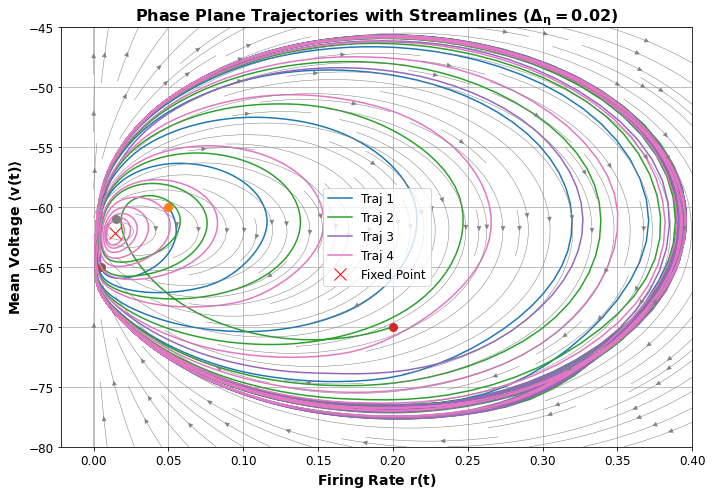

In [46]:
r_fp, v_fp, u_fp, s_fp, p_fp =  0.014028357470254547, -62.14663822071023, -16.15812593738466, 0.11605327615225841, 0.11605327615225841
etaBar = 0.5
Delta = 0.02
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.4, 25)
v = np.linspace(-80, -45, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines

plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.grid(True)
plt.title(r"Phase Plane Trajectories with Streamlines $\mathbf{(\Delta_{\eta} = 0.02)}$", fontsize=16, fontweight='bold')
plt.ylabel(r"Mean Voltage $\mathbf{\langle v(t) \rangle }$", fontsize=14, fontweight='bold')
plt.xlabel(r"Firing Rate $\mathbf{r(t)}$", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('TrajectoryPlot_DeltaEta_0.02.png')
plt.show()

In [47]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [0.0120 , -62.2695]  # initial guesses for r, v
etaBar = 0.5
Delta = 0.06
fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta, ))
r_fp, v_fp = fixed_point
u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

# Check additional conditions explicitly
dudt = a * (b * v_fp - u_fp) + d * r_fp
dsdt = -s_fp / tauS + p_jump * r_fp
dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

# Print all equilibrium variables
print(f"Delta = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

# Verify residuals for ALL equations
print("Residuals (should be close to zero):")
print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar, Delta))
print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

# Update guess for next iteration
initial_guess = [r_fp, v_fp]

Delta = 0.50, Fixed point (r, v, u, s, p): 0.016343456866104594, -62.40826094101792, -16.22614784466466, 0.13520554469661258, 0.13520554469661258
Residuals (should be close to zero):
dr/dt, dv/dt: [-8.957786769292486e-15, 2.3577251262452137e-12]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


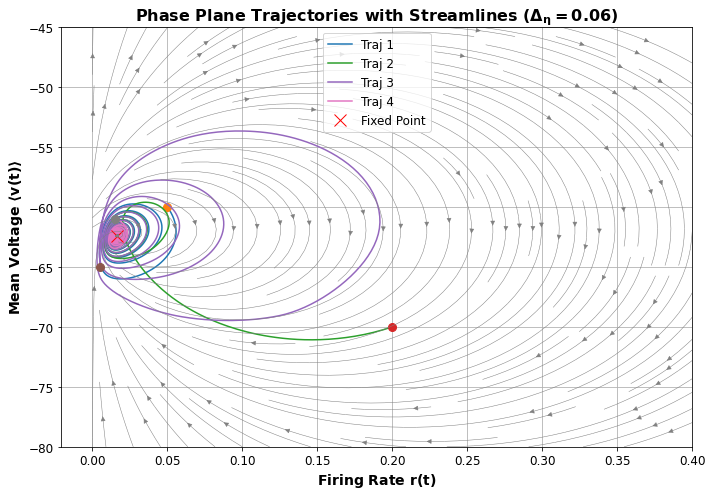

In [48]:
r_fp, v_fp, u_fp, s_fp, p_fp =   0.016343456866104594, -62.40826094101792, -16.22614784466466, 0.13520554469661258, 0.13520554469661258
etaBar = 0.5
Delta = 0.06
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.4, 25)
v = np.linspace(-80, -45, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines

plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.grid(True)
plt.title(r"Phase Plane Trajectories with Streamlines $\mathbf{(\Delta_{\eta} = 0.06)}$", fontsize=16, fontweight='bold')
plt.ylabel(r"Mean Voltage $\mathbf{\langle v(t) \rangle }$", fontsize=14, fontweight='bold')
plt.xlabel(r"Firing Rate $\mathbf{r(t)}$", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('TrajectoryPlot_DeltaEta_0.06.png')
plt.show()